# Rooftops Segmentation for Solar Panels Estimation Project

## Importing libraries

In [1]:
import os
import io
import shutil
import math
import time
from tqdm import tqdm

from functions import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

import cv2
from PIL import Image

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, concat, lit, array
from pyspark.sql.types import StringType, StructType, StructField, DoubleType, ArrayType, BinaryType

from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Parameters

In [2]:
# Paths
PROJECT_PATH = "/home/igor/MEGAsync/Faks/Geoprostorni sistemi/Projekat"
DATASET_PATH = "/home/igor/Projects/Geoinformatika/Data/Dataset"
RGB_DIR = f"{DATASET_PATH}/RGB images"
DEM_DIR = f"{DATASET_PATH}/DEM images"
DSM_DIR = f"{DATASET_PATH}/DSM images"
MASK_DIR = f"{DATASET_PATH}/Masks"
LOG_DIR = f"{PROJECT_PATH}/logs"
RESULT_IMAGES_DIR = f"{PROJECT_PATH}/raw results"
POST_PROCESS_DIR = f"{PROJECT_PATH}/post-processed results"
BEST_MODEL_PATH = "best_model.pth"
RESULTS_DATAFRAME_PATH = "results.csv"

# Train and evaluation parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
NUM_EPOCHS = 200
LEARNING_RATE = 0.001
IMAGE_SIZE = 250
TEST_SIZE = 0.2
RANDOM_STATE = 42
SQUARE_PIXEL_AREA = 0.25
SOLAR_PANEL_AREA = 1.62 

# Other
LINE = 100 * '-'
DOUBLE_LINE = 100 * '='

## Dataset preparation

### Spark session initialization

In [3]:
# Stop any existing Spark session
SparkSession.builder.getOrCreate().stop()

# Create a new Spark session
spark_preprocessing = SparkSession.builder.appName("images_preprocessing").getOrCreate()

24/07/11 13:54:30 WARN Utils: Your hostname, igor-desktop resolves to a loopback address: 127.0.1.1; using 192.168.1.2 instead (on interface enp2s0)
24/07/11 13:54:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/11 13:54:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Dataset class initialization

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.data = self.dataframe.to_dict("records") 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        
        rgb_image = Image.open(io.BytesIO(row["rgb_image"])).convert("RGB")
        dem_image = Image.open(io.BytesIO(row["dem_image"])).convert("L")
        dsm_image = Image.open(io.BytesIO(row["dsm_image"])).convert("L")
        mask = Image.open(io.BytesIO(row["mask"])).convert("L")

        if self.transform:
            rgb_image = self.transform(rgb_image)
            dem_image = self.transform(dem_image)
            dsm_image = self.transform(dsm_image)
            mask = self.transform(mask)

        combined_image = torch.cat((rgb_image, dem_image, dsm_image), dim=0)
        
        return combined_image, mask, row["image_name"]

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

### Data structuring and splitting

In [5]:
# Define schema for our data
schema = StructType([
    StructField("image_name", StringType(), True),
    StructField("rgb_image", BinaryType(), True),
    StructField("dem_image", BinaryType(), True),
    StructField("dsm_image", BinaryType(), True),
    StructField("mask", BinaryType(), True)
])

read_image_file_udf = udf(read_image_file, BinaryType())

# Create a DataFrame with image data
df = spark_preprocessing.createDataFrame([(name,) for name in os.listdir(RGB_DIR)], ["image_name"])

# Add full file paths
df = df.withColumn("rgb_path", concat(lit(RGB_DIR + "/"), df.image_name))
df = df.withColumn("dem_path", concat(lit(DEM_DIR + "/"), df.image_name))
df = df.withColumn("dsm_path", concat(lit(DSM_DIR + "/"), df.image_name))
df = df.withColumn("mask_path", concat(lit(MASK_DIR + "/"), df.image_name))

# Read image data
df = df.withColumn("rgb_image", read_image_file_udf(df.rgb_path))
df = df.withColumn("dem_image", read_image_file_udf(df.dem_path))
df = df.withColumn("dsm_image", read_image_file_udf(df.dsm_path))
df = df.withColumn("mask", read_image_file_udf(df.mask_path))

# Drop the path columns as they're no longer needed
df = df.drop("rgb_path", "dem_path", "dsm_path", "mask_path")

# Filter out rows where any of the images couldn't be read
df = df.filter(
    (df.rgb_image.isNotNull()) & 
    (df.dem_image.isNotNull()) & 
    (df.dsm_image.isNotNull()) & 
    (df.mask.isNotNull())
)

# Split the data into training and validation sets
train_df, val_df = df.randomSplit([1 - TEST_SIZE, TEST_SIZE], seed=RANDOM_STATE)

# Convert Spark DataFrames to Pandas DataFrames
train_df = train_df.toPandas()
val_df = val_df.toPandas()

# Stop the Spark session
spark_preprocessing.stop()

### Datasets and Dataloaders creation

In [6]:
train_dataset = SatelliteDataset(train_df, transform=transform)
val_dataset = SatelliteDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model architecture definition

In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = nn.functional.interpolate(x, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)
        return x

## Evaluation

### Model initialization

In [8]:
model = ConvAutoencoder().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Result and log directories existence checking and cleaning

In [9]:
for directory in [LOG_DIR, RESULT_IMAGES_DIR, POST_PROCESS_DIR]:
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

### Training and validation

In [10]:
# Initialize TensorBoard
writer = SummaryWriter(LOG_DIR)

# Training loop with best model saving
best_auc = 0.0
start_time = time.time()

print(DOUBLE_LINE)
print("TRAINING AND VALIDATION PROCESS STARTED")
print(DOUBLE_LINE)

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    spark_training = SparkSession.builder.appName("training").getOrCreate()

    train_loss = train(model, train_loader, criterion, optimizer, DEVICE)
    val_auc = evaluate(model, val_loader, DEVICE, spark_training)
    
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("AUC-ROC/val", val_auc, epoch)
    
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), BEST_MODEL_PATH)

    spark_training.stop()
    
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_minutes = int(epoch_duration // 60)
    epoch_seconds = int(epoch_duration % 60)
    
    print(LINE)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {train_loss:.4f}, AUC-ROC: {val_auc:.4f}, Time: {epoch_minutes}:{epoch_seconds}")

total_duration = time.time() - start_time
total_hours = int(total_duration // 3600)
total_minutes = int((total_duration % 3600) // 60)
total_seconds = round(total_duration % 60)

print(DOUBLE_LINE)
print(f"Best model saved with AUC-ROC: {best_auc:.4f}")
print(f"Total training time: {total_hours}:{total_minutes}:{total_seconds}")
print(DOUBLE_LINE)

writer.add_text("Training Summary", f"Total training time: {total_hours}:{total_minutes}:{total_seconds}")
writer.add_scalar("Best AUC-ROC", best_auc)
writer.close()

TRAINING AND VALIDATION PROCESS STARTED


/home/igor/miniconda3/envs/geoinformatics/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
24/07/11 13:55:32 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 1/200, Loss: 0.2973, AUC-ROC: 0.5000, Time: 0:44


24/07/11 13:56:13 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 2/200, Loss: 0.2421, AUC-ROC: 0.5000, Time: 0:40


24/07/11 13:56:53 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 3/200, Loss: 0.2051, AUC-ROC: 0.5000, Time: 0:41


24/07/11 13:57:34 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 4/200, Loss: 0.1586, AUC-ROC: 0.7385, Time: 0:39


24/07/11 13:58:15 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 5/200, Loss: 0.1518, AUC-ROC: 0.6667, Time: 0:42


24/07/11 13:58:57 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 6/200, Loss: 0.1517, AUC-ROC: 0.8119, Time: 0:40


24/07/11 13:59:37 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 7/200, Loss: 0.1227, AUC-ROC: 0.7674, Time: 0:39


24/07/11 14:00:17 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 8/200, Loss: 0.1065, AUC-ROC: 0.8540, Time: 0:41


24/07/11 14:01:00 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 9/200, Loss: 0.1714, AUC-ROC: 0.7441, Time: 0:43


24/07/11 14:01:48 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 10/200, Loss: 0.1229, AUC-ROC: 0.7743, Time: 0:51


24/07/11 14:02:37 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 11/200, Loss: 0.1138, AUC-ROC: 0.8090, Time: 0:45


24/07/11 14:03:24 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 12/200, Loss: 0.0986, AUC-ROC: 0.8290, Time: 0:48


24/07/11 14:04:11 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 13/200, Loss: 0.1132, AUC-ROC: 0.6262, Time: 0:45


24/07/11 14:04:57 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 14/200, Loss: 0.1147, AUC-ROC: 0.7089, Time: 0:45


24/07/11 14:05:42 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 15/200, Loss: 0.1062, AUC-ROC: 0.8269, Time: 0:45


24/07/11 14:06:29 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 16/200, Loss: 0.0882, AUC-ROC: 0.7866, Time: 0:48


24/07/11 14:07:14 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 17/200, Loss: 0.0850, AUC-ROC: 0.7860, Time: 0:43


24/07/11 14:07:59 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 18/200, Loss: 0.0865, AUC-ROC: 0.7754, Time: 0:46


24/07/11 14:08:46 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 19/200, Loss: 0.0689, AUC-ROC: 0.8220, Time: 0:45


24/07/11 14:09:33 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 20/200, Loss: 0.0791, AUC-ROC: 0.6045, Time: 0:48


24/07/11 14:10:26 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 21/200, Loss: 0.0831, AUC-ROC: 0.8294, Time: 0:51


24/07/11 14:11:14 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 22/200, Loss: 0.0695, AUC-ROC: 0.7651, Time: 0:49


24/07/11 14:12:00 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 23/200, Loss: 0.0716, AUC-ROC: 0.8552, Time: 0:44


24/07/11 14:12:45 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 24/200, Loss: 0.0660, AUC-ROC: 0.8664, Time: 0:44


24/07/11 14:13:28 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 25/200, Loss: 0.0675, AUC-ROC: 0.8617, Time: 0:43


24/07/11 14:14:13 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 26/200, Loss: 0.0629, AUC-ROC: 0.9223, Time: 0:43


24/07/11 14:14:56 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 27/200, Loss: 0.0907, AUC-ROC: 0.9071, Time: 0:43


24/07/11 14:15:39 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 28/200, Loss: 0.0780, AUC-ROC: 0.8756, Time: 0:43


24/07/11 14:16:22 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 29/200, Loss: 0.0677, AUC-ROC: 0.8947, Time: 0:45


24/07/11 14:17:06 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 30/200, Loss: 0.0538, AUC-ROC: 0.8760, Time: 0:41


24/07/11 14:17:49 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 31/200, Loss: 0.0568, AUC-ROC: 0.8927, Time: 0:44


24/07/11 14:18:35 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 32/200, Loss: 0.0567, AUC-ROC: 0.9279, Time: 0:44


24/07/11 14:19:18 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 33/200, Loss: 0.0539, AUC-ROC: 0.7878, Time: 0:43


24/07/11 14:20:02 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 34/200, Loss: 0.0751, AUC-ROC: 0.9113, Time: 0:43


24/07/11 14:20:46 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 35/200, Loss: 0.0624, AUC-ROC: 0.9048, Time: 0:44


24/07/11 14:21:33 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 36/200, Loss: 0.0579, AUC-ROC: 0.8719, Time: 0:48


24/07/11 14:22:20 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 37/200, Loss: 0.0510, AUC-ROC: 0.9191, Time: 0:45


24/07/11 14:23:04 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 38/200, Loss: 0.0497, AUC-ROC: 0.8785, Time: 0:46


24/07/11 14:23:50 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 39/200, Loss: 0.0584, AUC-ROC: 0.9051, Time: 0:43


24/07/11 14:24:37 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 40/200, Loss: 0.0510, AUC-ROC: 0.9244, Time: 0:47


24/07/11 14:25:24 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 41/200, Loss: 0.0469, AUC-ROC: 0.9012, Time: 0:46


24/07/11 14:26:09 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 42/200, Loss: 0.0480, AUC-ROC: 0.8066, Time: 0:45


24/07/11 14:26:56 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 43/200, Loss: 0.0684, AUC-ROC: 0.8926, Time: 0:48


24/07/11 14:27:42 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 44/200, Loss: 0.0615, AUC-ROC: 0.9171, Time: 0:43


24/07/11 14:28:29 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 45/200, Loss: 0.0532, AUC-ROC: 0.9043, Time: 0:46


24/07/11 14:29:16 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 46/200, Loss: 0.0475, AUC-ROC: 0.8771, Time: 0:49


24/07/11 14:30:03 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 47/200, Loss: 0.0531, AUC-ROC: 0.8804, Time: 0:44


24/07/11 14:30:50 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 48/200, Loss: 0.0450, AUC-ROC: 0.9268, Time: 0:47


24/07/11 14:31:37 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 49/200, Loss: 0.0501, AUC-ROC: 0.8828, Time: 0:49


24/07/11 14:32:25 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 50/200, Loss: 0.0566, AUC-ROC: 0.9117, Time: 0:45


24/07/11 14:33:11 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 51/200, Loss: 0.0435, AUC-ROC: 0.9118, Time: 0:46


24/07/11 14:33:58 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 52/200, Loss: 0.0453, AUC-ROC: 0.8959, Time: 0:50


24/07/11 14:34:45 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 53/200, Loss: 0.0422, AUC-ROC: 0.9016, Time: 0:42


24/07/11 14:35:32 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 54/200, Loss: 0.0406, AUC-ROC: 0.9354, Time: 0:49


24/07/11 14:36:19 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 55/200, Loss: 0.0437, AUC-ROC: 0.8971, Time: 0:44


24/07/11 14:37:07 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 56/200, Loss: 0.0448, AUC-ROC: 0.9387, Time: 0:47


24/07/11 14:37:53 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 57/200, Loss: 0.0509, AUC-ROC: 0.8838, Time: 0:45


24/07/11 14:38:38 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 58/200, Loss: 0.0660, AUC-ROC: 0.9403, Time: 0:45


24/07/11 14:39:23 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 59/200, Loss: 0.0455, AUC-ROC: 0.9149, Time: 0:46


24/07/11 14:40:12 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 60/200, Loss: 0.0492, AUC-ROC: 0.9304, Time: 0:46


24/07/11 14:40:56 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 61/200, Loss: 0.0456, AUC-ROC: 0.9037, Time: 0:44


24/07/11 14:41:41 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 62/200, Loss: 0.0404, AUC-ROC: 0.9050, Time: 0:45


24/07/11 14:42:26 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 63/200, Loss: 0.0395, AUC-ROC: 0.8290, Time: 0:45


24/07/11 14:43:14 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 64/200, Loss: 0.0423, AUC-ROC: 0.8994, Time: 0:50


24/07/11 14:44:03 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 65/200, Loss: 0.0397, AUC-ROC: 0.9280, Time: 0:45


24/07/11 14:44:48 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 66/200, Loss: 0.0400, AUC-ROC: 0.9014, Time: 0:45


24/07/11 14:45:33 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 67/200, Loss: 0.0388, AUC-ROC: 0.8852, Time: 0:44


24/07/11 14:46:20 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 68/200, Loss: 0.0384, AUC-ROC: 0.9282, Time: 0:46


24/07/11 14:47:04 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 69/200, Loss: 0.0362, AUC-ROC: 0.9407, Time: 0:45


24/07/11 14:47:51 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 70/200, Loss: 0.0469, AUC-ROC: 0.9140, Time: 0:44


24/07/11 14:48:36 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 71/200, Loss: 0.0388, AUC-ROC: 0.9261, Time: 0:45


24/07/11 14:49:22 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 72/200, Loss: 0.0351, AUC-ROC: 0.9150, Time: 0:46


24/07/11 14:50:10 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 73/200, Loss: 0.0347, AUC-ROC: 0.9377, Time: 0:48


24/07/11 14:50:54 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 74/200, Loss: 0.0329, AUC-ROC: 0.9242, Time: 0:43


24/07/11 14:51:36 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 75/200, Loss: 0.0334, AUC-ROC: 0.9265, Time: 0:42


24/07/11 14:52:17 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 76/200, Loss: 0.0453, AUC-ROC: 0.9279, Time: 0:39


24/07/11 14:52:54 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 77/200, Loss: 0.0386, AUC-ROC: 0.9268, Time: 0:37


24/07/11 14:53:33 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 78/200, Loss: 0.0332, AUC-ROC: 0.9092, Time: 0:38


24/07/11 14:54:10 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 79/200, Loss: 0.0312, AUC-ROC: 0.9165, Time: 0:37


24/07/11 14:54:48 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 80/200, Loss: 0.0296, AUC-ROC: 0.9343, Time: 0:38


24/07/11 14:55:25 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 81/200, Loss: 0.0288, AUC-ROC: 0.9369, Time: 0:37


24/07/11 14:56:06 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 82/200, Loss: 0.0290, AUC-ROC: 0.9305, Time: 0:41


24/07/11 14:56:45 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 83/200, Loss: 0.0295, AUC-ROC: 0.8837, Time: 0:37


24/07/11 14:57:22 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 84/200, Loss: 0.1423, AUC-ROC: 0.6445, Time: 0:37


24/07/11 14:58:01 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 85/200, Loss: 0.0931, AUC-ROC: 0.8392, Time: 0:38


24/07/11 14:58:39 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 86/200, Loss: 0.0735, AUC-ROC: 0.9125, Time: 0:37


24/07/11 14:59:16 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 87/200, Loss: 0.0640, AUC-ROC: 0.8682, Time: 0:38


24/07/11 14:59:55 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 88/200, Loss: 0.0525, AUC-ROC: 0.8316, Time: 0:37


24/07/11 15:00:35 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 89/200, Loss: 0.0473, AUC-ROC: 0.9238, Time: 0:43


24/07/11 15:01:23 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 90/200, Loss: 0.0499, AUC-ROC: 0.8603, Time: 0:44


24/07/11 15:02:09 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 91/200, Loss: 0.0432, AUC-ROC: 0.9322, Time: 0:47


24/07/11 15:03:04 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 92/200, Loss: 0.0407, AUC-ROC: 0.9015, Time: 0:56


24/07/11 15:03:55 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 93/200, Loss: 0.0395, AUC-ROC: 0.8567, Time: 0:50


24/07/11 15:04:41 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 94/200, Loss: 0.0474, AUC-ROC: 0.9249, Time: 0:50


24/07/11 15:05:33 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 95/200, Loss: 0.0462, AUC-ROC: 0.9017, Time: 0:47


24/07/11 15:06:16 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 96/200, Loss: 0.0367, AUC-ROC: 0.9373, Time: 0:42


24/07/11 15:07:03 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 97/200, Loss: 0.0450, AUC-ROC: 0.8875, Time: 0:49


24/07/11 15:07:51 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 98/200, Loss: 0.0339, AUC-ROC: 0.8998, Time: 0:44


24/07/11 15:08:35 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 99/200, Loss: 0.0320, AUC-ROC: 0.9165, Time: 0:46


24/07/11 15:09:19 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 100/200, Loss: 0.0287, AUC-ROC: 0.9193, Time: 0:42


24/07/11 15:10:04 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 101/200, Loss: 0.0282, AUC-ROC: 0.9148, Time: 0:44


24/07/11 15:10:45 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 102/200, Loss: 0.0330, AUC-ROC: 0.8920, Time: 0:42


24/07/11 15:11:30 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 103/200, Loss: 0.0276, AUC-ROC: 0.9064, Time: 0:44


24/07/11 15:12:12 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 104/200, Loss: 0.0267, AUC-ROC: 0.9157, Time: 0:42


24/07/11 15:12:56 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 105/200, Loss: 0.0240, AUC-ROC: 0.9169, Time: 0:43


24/07/11 15:13:38 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 106/200, Loss: 0.0278, AUC-ROC: 0.8859, Time: 0:41


24/07/11 15:14:22 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 107/200, Loss: 0.0260, AUC-ROC: 0.9117, Time: 0:44


24/07/11 15:15:05 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 108/200, Loss: 0.0220, AUC-ROC: 0.9263, Time: 0:43


24/07/11 15:15:49 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 109/200, Loss: 0.0201, AUC-ROC: 0.9208, Time: 0:43


24/07/11 15:16:32 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 110/200, Loss: 0.0184, AUC-ROC: 0.9323, Time: 0:42


24/07/11 15:17:14 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 111/200, Loss: 0.0186, AUC-ROC: 0.9227, Time: 0:42


24/07/11 15:17:57 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 112/200, Loss: 0.0174, AUC-ROC: 0.9266, Time: 0:43


24/07/11 15:18:38 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 113/200, Loss: 0.0284, AUC-ROC: 0.9174, Time: 0:40


24/07/11 15:19:23 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 114/200, Loss: 0.0175, AUC-ROC: 0.9127, Time: 0:46


24/07/11 15:20:09 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 115/200, Loss: 0.0155, AUC-ROC: 0.9272, Time: 0:43


24/07/11 15:20:51 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 116/200, Loss: 0.0161, AUC-ROC: 0.8655, Time: 0:42


24/07/11 15:21:34 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 117/200, Loss: 0.0538, AUC-ROC: 0.9399, Time: 0:41


24/07/11 15:22:16 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 118/200, Loss: 0.0290, AUC-ROC: 0.9066, Time: 0:42


24/07/11 15:23:00 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 119/200, Loss: 0.0298, AUC-ROC: 0.8973, Time: 0:43


24/07/11 15:23:41 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 120/200, Loss: 0.0187, AUC-ROC: 0.9196, Time: 0:41


24/07/11 15:24:25 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 121/200, Loss: 0.0154, AUC-ROC: 0.9223, Time: 0:46


24/07/11 15:25:11 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 122/200, Loss: 0.0138, AUC-ROC: 0.9239, Time: 0:43


24/07/11 15:25:53 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 123/200, Loss: 0.0130, AUC-ROC: 0.9175, Time: 0:43


24/07/11 15:26:36 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 124/200, Loss: 0.0122, AUC-ROC: 0.9128, Time: 0:42


24/07/11 15:27:20 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 125/200, Loss: 0.0115, AUC-ROC: 0.9119, Time: 0:43


24/07/11 15:28:01 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 126/200, Loss: 0.0122, AUC-ROC: 0.9210, Time: 0:41


24/07/11 15:28:46 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 127/200, Loss: 0.0109, AUC-ROC: 0.9234, Time: 0:45


24/07/11 15:29:29 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 128/200, Loss: 0.0113, AUC-ROC: 0.9117, Time: 0:42


24/07/11 15:30:10 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 129/200, Loss: 0.0118, AUC-ROC: 0.9231, Time: 0:41


24/07/11 15:30:54 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 130/200, Loss: 0.0097, AUC-ROC: 0.9165, Time: 0:46


24/07/11 15:31:39 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 131/200, Loss: 0.0091, AUC-ROC: 0.9250, Time: 0:42


24/07/11 15:32:17 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 132/200, Loss: 0.0087, AUC-ROC: 0.9206, Time: 0:37


24/07/11 15:32:55 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 133/200, Loss: 0.0083, AUC-ROC: 0.9210, Time: 0:39


24/07/11 15:33:35 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 134/200, Loss: 0.0081, AUC-ROC: 0.9165, Time: 0:38


24/07/11 15:34:13 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 135/200, Loss: 0.0079, AUC-ROC: 0.9218, Time: 0:37


24/07/11 15:34:51 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 136/200, Loss: 0.0076, AUC-ROC: 0.9215, Time: 0:37


24/07/11 15:35:28 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 137/200, Loss: 0.0802, AUC-ROC: 0.5017, Time: 0:37


24/07/11 15:36:07 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 138/200, Loss: 0.2060, AUC-ROC: 0.5382, Time: 0:38


24/07/11 15:36:46 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 139/200, Loss: 0.1647, AUC-ROC: 0.5559, Time: 0:40


24/07/11 15:37:25 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 140/200, Loss: 0.1532, AUC-ROC: 0.6148, Time: 0:37


24/07/11 15:38:02 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 141/200, Loss: 0.1463, AUC-ROC: 0.5931, Time: 0:37


24/07/11 15:38:40 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 142/200, Loss: 0.1382, AUC-ROC: 0.7082, Time: 0:37


24/07/11 15:39:17 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 143/200, Loss: 0.1364, AUC-ROC: 0.6622, Time: 0:37


24/07/11 15:39:55 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 144/200, Loss: 0.1306, AUC-ROC: 0.7094, Time: 0:37


24/07/11 15:40:31 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 145/200, Loss: 0.1180, AUC-ROC: 0.7750, Time: 0:37


24/07/11 15:41:09 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 146/200, Loss: 0.1112, AUC-ROC: 0.7538, Time: 0:37


24/07/11 15:41:48 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 147/200, Loss: 0.1046, AUC-ROC: 0.7224, Time: 0:39


24/07/11 15:42:27 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 148/200, Loss: 0.0983, AUC-ROC: 0.7633, Time: 0:38


24/07/11 15:43:05 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 149/200, Loss: 0.1043, AUC-ROC: 0.7556, Time: 0:37


24/07/11 15:43:42 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 150/200, Loss: 0.0973, AUC-ROC: 0.8600, Time: 0:37


24/07/11 15:44:21 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 151/200, Loss: 0.0850, AUC-ROC: 0.8220, Time: 0:38


24/07/11 15:44:59 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 152/200, Loss: 0.0817, AUC-ROC: 0.8393, Time: 0:37


24/07/11 15:45:36 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 153/200, Loss: 0.0758, AUC-ROC: 0.8086, Time: 0:36


24/07/11 15:46:14 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 154/200, Loss: 0.0789, AUC-ROC: 0.8456, Time: 0:38


24/07/11 15:46:51 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 155/200, Loss: 0.0764, AUC-ROC: 0.8436, Time: 0:37


24/07/11 15:47:29 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 156/200, Loss: 0.0698, AUC-ROC: 0.9183, Time: 0:37


24/07/11 15:48:06 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 157/200, Loss: 0.0600, AUC-ROC: 0.7925, Time: 0:38


24/07/11 15:48:44 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 158/200, Loss: 0.0606, AUC-ROC: 0.8609, Time: 0:37


24/07/11 15:49:24 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 159/200, Loss: 0.0576, AUC-ROC: 0.9327, Time: 0:41


24/07/11 15:50:02 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 160/200, Loss: 0.0659, AUC-ROC: 0.8242, Time: 0:36


24/07/11 15:50:40 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 161/200, Loss: 0.0555, AUC-ROC: 0.8729, Time: 0:37


24/07/11 15:51:18 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 162/200, Loss: 0.0515, AUC-ROC: 0.8490, Time: 0:37


24/07/11 15:51:59 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 163/200, Loss: 0.0613, AUC-ROC: 0.9208, Time: 0:41


24/07/11 15:52:40 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 164/200, Loss: 0.0531, AUC-ROC: 0.9228, Time: 0:41


24/07/11 15:53:24 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 165/200, Loss: 0.0572, AUC-ROC: 0.8788, Time: 0:43


24/07/11 15:54:09 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 166/200, Loss: 0.0503, AUC-ROC: 0.9028, Time: 0:45


24/07/11 15:54:54 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 167/200, Loss: 0.0480, AUC-ROC: 0.7920, Time: 0:43


24/07/11 15:55:38 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 168/200, Loss: 0.0479, AUC-ROC: 0.8828, Time: 0:44


24/07/11 15:56:20 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 169/200, Loss: 0.0459, AUC-ROC: 0.8686, Time: 0:42


24/07/11 15:57:08 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 170/200, Loss: 0.0449, AUC-ROC: 0.8680, Time: 0:48


24/07/11 15:57:51 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 171/200, Loss: 0.0460, AUC-ROC: 0.9217, Time: 0:42


24/07/11 15:58:39 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 172/200, Loss: 0.0448, AUC-ROC: 0.9167, Time: 0:48


24/07/11 15:59:25 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 173/200, Loss: 0.0434, AUC-ROC: 0.9256, Time: 0:46


24/07/11 16:00:14 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 174/200, Loss: 0.0638, AUC-ROC: 0.8993, Time: 0:51


24/07/11 16:01:06 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 175/200, Loss: 0.0474, AUC-ROC: 0.9306, Time: 0:50


24/07/11 16:01:56 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 176/200, Loss: 0.0417, AUC-ROC: 0.8821, Time: 0:51


24/07/11 16:02:47 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 177/200, Loss: 0.0445, AUC-ROC: 0.8755, Time: 0:52


24/07/11 16:03:40 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 178/200, Loss: 0.0457, AUC-ROC: 0.8862, Time: 0:54


24/07/11 16:04:32 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 179/200, Loss: 0.0402, AUC-ROC: 0.8827, Time: 0:46


24/07/11 16:05:20 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 180/200, Loss: 0.0394, AUC-ROC: 0.8905, Time: 0:47


24/07/11 16:06:07 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 181/200, Loss: 0.0393, AUC-ROC: 0.8704, Time: 0:59


24/07/11 16:07:05 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 182/200, Loss: 0.0382, AUC-ROC: 0.9100, Time: 1:0


24/07/11 16:08:04 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 183/200, Loss: 0.0385, AUC-ROC: 0.9070, Time: 0:45


24/07/11 16:08:49 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 184/200, Loss: 0.0345, AUC-ROC: 0.9145, Time: 0:44


24/07/11 16:09:40 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 185/200, Loss: 0.0342, AUC-ROC: 0.9033, Time: 0:50


24/07/11 16:10:27 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 186/200, Loss: 0.0328, AUC-ROC: 0.8995, Time: 0:46


24/07/11 16:11:13 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 187/200, Loss: 0.0331, AUC-ROC: 0.9278, Time: 0:46


24/07/11 16:11:57 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 188/200, Loss: 0.0318, AUC-ROC: 0.9176, Time: 0:43


24/07/11 16:12:42 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 189/200, Loss: 0.0313, AUC-ROC: 0.9149, Time: 0:46


24/07/11 16:13:29 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 190/200, Loss: 0.0378, AUC-ROC: 0.8674, Time: 0:45


24/07/11 16:14:15 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 191/200, Loss: 0.0326, AUC-ROC: 0.9061, Time: 0:46


24/07/11 16:14:58 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 192/200, Loss: 0.0295, AUC-ROC: 0.9151, Time: 0:43


24/07/11 16:15:42 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 193/200, Loss: 0.0275, AUC-ROC: 0.9165, Time: 0:44


24/07/11 16:16:28 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 194/200, Loss: 0.0276, AUC-ROC: 0.9015, Time: 0:44


24/07/11 16:17:11 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 195/200, Loss: 0.0271, AUC-ROC: 0.9083, Time: 0:43


24/07/11 16:17:55 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 196/200, Loss: 0.0429, AUC-ROC: 0.9110, Time: 0:46


24/07/11 16:18:44 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 197/200, Loss: 0.0373, AUC-ROC: 0.9128, Time: 0:49


24/07/11 16:19:29 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 198/200, Loss: 0.0260, AUC-ROC: 0.8810, Time: 0:42


24/07/11 16:20:13 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 199/200, Loss: 0.0261, AUC-ROC: 0.9100, Time: 0:43


24/07/11 16:20:57 WARN TaskSetManager: Stage 0 contains a task of very large size (15067 KiB). The maximum recommended task size is 1000 KiB.


----------------------------------------------------------------------------------------------------
Epoch 200/200, Loss: 0.0265, AUC-ROC: 0.9097, Time: 0:44
Best model saved with AUC-ROC: 0.9407
Total training time: 2:26:10


### Best model loading

In [11]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))

<All keys matched successfully>

### Evaluation of training dataset

In [12]:
# Save predictions on the training dataset
print(DOUBLE_LINE) 
print("Evaluation of training dataset")
print(DOUBLE_LINE) 
save_predictions(model, val_loader, DEVICE, RESULT_IMAGES_DIR)

print(DOUBLE_LINE)
print(f"Predicted masks saved to {RESULT_IMAGES_DIR}")
print(DOUBLE_LINE)

Evaluation of training dataset


Saving predictions: 100%|██████████| 148/148 [00:02<00:00, 67.12it/s]

Predicted masks saved to /home/igor/MEGAsync/Faks/Geoprostorni sistemi/Projekat/raw results


### Post-processing of result images

In [13]:
print(DOUBLE_LINE)
print("Post-processing of result images")
print(DOUBLE_LINE)

image_files = os.listdir(RESULT_IMAGES_DIR)
for image_name in tqdm(image_files, desc="Post-processing images"):
    image_path = os.path.join(RESULT_IMAGES_DIR, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Conditional median filtering
    image = conditional_median_filter(image)

    # Image erosion
    kernel = np.ones((3, 3), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)

    # Image dilation
    image = cv2.dilate(image, kernel, iterations=1)

    # Invert pixel values
    image = 255 - image

    # Save processed image
    post_processed_path = os.path.join(POST_PROCESS_DIR, image_name)
    cv2.imwrite(post_processed_path, image)

print(DOUBLE_LINE)
print(f"Post-processed images from {RESULT_IMAGES_DIR} saved to {POST_PROCESS_DIR}")
print(DOUBLE_LINE)

Post-processing of result images


Post-processing images: 100%|██████████| 148/148 [01:40<00:00,  1.48it/s]

Post-processed images from /home/igor/MEGAsync/Faks/Geoprostorni sistemi/Projekat/raw results saved to /home/igor/MEGAsync/Faks/Geoprostorni sistemi/Projekat/post-processed results


### Example image evaluation results showing

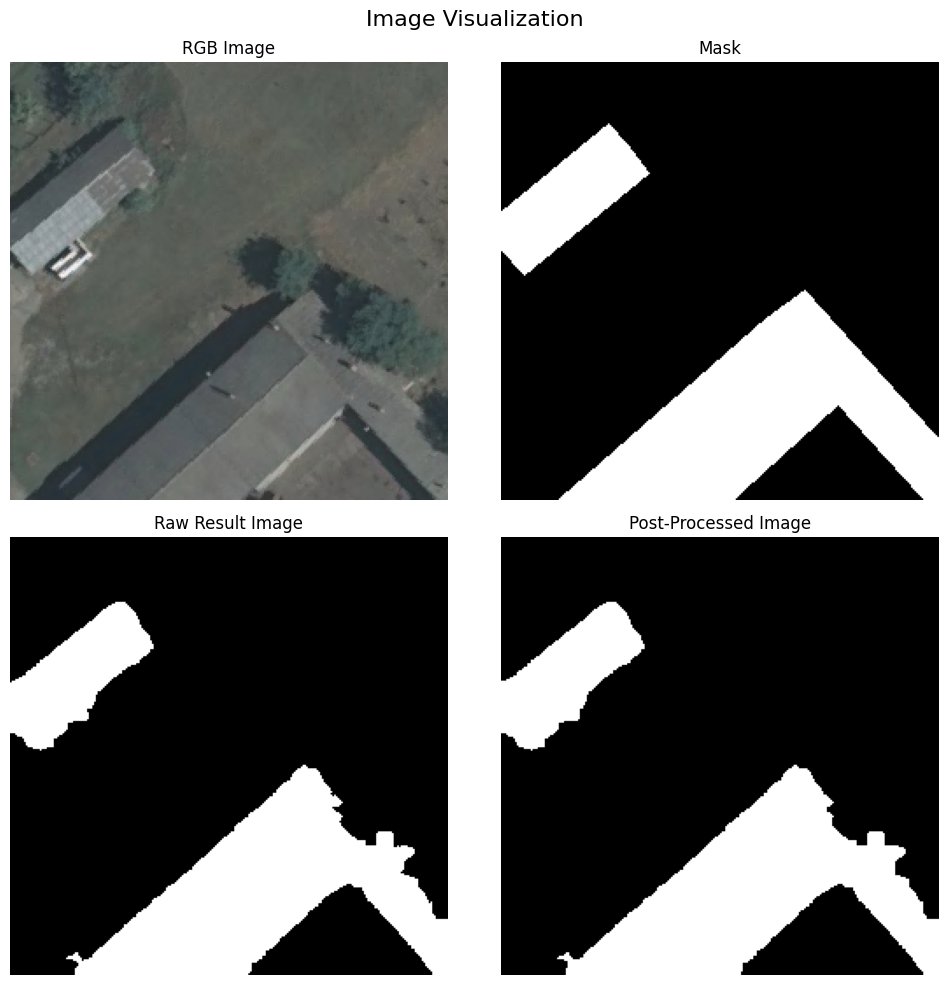

In [14]:
example_image_name = image_files[0] 

# Paths for images
rgb_image_path = os.path.join(RGB_DIR, example_image_name)
mask_image_path = os.path.join(MASK_DIR, example_image_name)
raw_result_image_path = os.path.join(RESULT_IMAGES_DIR, example_image_name)
post_processed_image_path = os.path.join(POST_PROCESS_DIR, example_image_name)

# Loading images
rgb_image = Image.open(rgb_image_path).convert("RGB")
mask_image = Image.open(mask_image_path).convert("L")
raw_result_image = Image.open(raw_result_image_path).convert("L")
post_processed_image = Image.open(post_processed_image_path).convert("L")

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(rgb_image)
axes[0, 0].set_title("RGB Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(mask_image, cmap="gray")
axes[0, 1].set_title("Mask")
axes[0, 1].axis("off")

axes[1, 0].imshow(raw_result_image, cmap="gray")
axes[1, 0].set_title("Raw Result Image")
axes[1, 0].axis("off")

axes[1, 1].imshow(post_processed_image, cmap="gray")
axes[1, 1].set_title("Post-Processed Image")
axes[1, 1].axis("off")

fig.suptitle("Image Visualization", fontsize=16)

plt.tight_layout()
plt.show()

### Roofs and solar panels estimation

In [17]:
spark_post_processing = SparkSession.builder.appName("images_post_processing").getOrCreate()

# Define schema for the results DataFrame
schema = StructType([
    StructField("Image name", StringType(), True),
    StructField("IoU - raw result [%]", DoubleType(), True),
    StructField("IoU - post-processed result [%]", DoubleType(), True),
    StructField("Objects (> 1% total area)", DoubleType(), True),
    StructField("Roof area [m^2] - mapped", DoubleType(), True),
    StructField("Roof area [m^2] - raw result", DoubleType(), True),
    StructField("Roof area [m^2] - post-processed result", DoubleType(), True),
    StructField("Solar panels estimation - mapped", DoubleType(), True),
    StructField("Solar panels estimation - raw result", DoubleType(), True),
    StructField("Solar panels estimation - post-processed result", DoubleType(), True)
])

print(DOUBLE_LINE)
print("Roofs and solar panels estimation for results")
print(DOUBLE_LINE)

# Process each image and collect results
results = []

for image_name in tqdm(image_files, desc="Processing images"):
    # Paths for images
    mask_image_path = os.path.join(MASK_DIR, image_name)
    raw_result_image_path = os.path.join(RESULT_IMAGES_DIR, image_name)
    post_processed_image_path = os.path.join(POST_PROCESS_DIR, image_name)

    # Calculate IoU for raw and post-processed results
    iou_raw = float(calculate_iou(mask_image_path, raw_result_image_path))
    iou_post_processed = float(calculate_iou(mask_image_path, post_processed_image_path))

    # Calculate for mask
    large_objects_count = float(count_large_objects(mask_image_path, percentage_threshold=1))
    mask_areas = find_largest_objects_areas(mask_image_path, N=int(large_objects_count), square_pixel_area=SQUARE_PIXEL_AREA)
    mask_roof_areas = [float(roof_area_calculation(area)) for area in mask_areas]
    mask_solar_panels = float(sum([solar_panels_estimation(roof_area, SOLAR_PANEL_AREA) for roof_area in mask_roof_areas]))
    
    # Calculate for raw result image using N from mask
    raw_areas = find_largest_objects_areas(raw_result_image_path, N=int(large_objects_count), square_pixel_area=SQUARE_PIXEL_AREA)
    raw_roof_areas = [float(roof_area_calculation(area)) for area in raw_areas]
    raw_solar_panels = float(sum([solar_panels_estimation(roof_area, SOLAR_PANEL_AREA) for roof_area in raw_roof_areas]))
    
    # Calculate for post-processed result image using N from mask
    post_processed_areas = find_largest_objects_areas(post_processed_image_path, N=int(large_objects_count), square_pixel_area=SQUARE_PIXEL_AREA)
    post_processed_roof_areas = [float(roof_area_calculation(area)) for area in post_processed_areas]
    post_processed_solar_panels = float(sum([solar_panels_estimation(roof_area, SOLAR_PANEL_AREA) for roof_area in post_processed_roof_areas]))
    
    # Append results to list
    results.append((image_name, iou_raw, iou_post_processed, large_objects_count,
                    float(sum(mask_roof_areas)), float(sum(raw_roof_areas)), float(sum(post_processed_roof_areas)),
                    mask_solar_panels, raw_solar_panels, post_processed_solar_panels))

# Convert list of results to Spark DataFrame
results_df = spark_post_processing.createDataFrame(results, schema)

# Save DataFrame to a temporary directory
results_df.coalesce(1).write.csv("/tmp/results_temp", header=True, mode="overwrite")

# Find the part file and move it to the final location
for file_name in os.listdir("/tmp/results_temp"):
    if file_name.startswith("part-"):
        shutil.move(os.path.join("/tmp/results_temp", file_name), RESULTS_DATAFRAME_PATH)
        break

# Remove the temporary directory
shutil.rmtree("/tmp/results_temp")

print(DOUBLE_LINE)
print(f"Results saved to {RESULTS_DATAFRAME_PATH}")
print(DOUBLE_LINE)

Roofs and solar panels estimation for results


Processing images: 100%|██████████| 148/148 [00:00<00:00, 269.85it/s]


Results saved to results.csv


### Results view

In [18]:
results_df.show(10)

+---------------+--------------------+-------------------------------+-------------------------+------------------------+----------------------------+---------------------------------------+--------------------------------+------------------------------------+-----------------------------------------------+
|     Image name|IoU - raw result [%]|IoU - post-processed result [%]|Objects (> 1% total area)|Roof area [m^2] - mapped|Roof area [m^2] - raw result|Roof area [m^2] - post-processed result|Solar panels estimation - mapped|Solar panels estimation - raw result|Solar panels estimation - post-processed result|
+---------------+--------------------+-------------------------------+-------------------------+------------------------+----------------------------+---------------------------------------+--------------------------------+------------------------------------+-----------------------------------------------+
|patch_41_83.png|               91.87|                          91.87|   

### Results statistics

In [19]:
results_df.describe().show()

# Stop the Spark session
spark_post_processing.stop()

24/07/11 16:26:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------+--------------------+-------------------------------+-------------------------+------------------------+----------------------------+---------------------------------------+--------------------------------+------------------------------------+-----------------------------------------------+
|summary|    Image name|IoU - raw result [%]|IoU - post-processed result [%]|Objects (> 1% total area)|Roof area [m^2] - mapped|Roof area [m^2] - raw result|Roof area [m^2] - post-processed result|Solar panels estimation - mapped|Solar panels estimation - raw result|Solar panels estimation - post-processed result|
+-------+--------------+--------------------+-------------------------------+-------------------------+------------------------+----------------------------+---------------------------------------+--------------------------------+------------------------------------+-----------------------------------------------+
|  count|           148|                 148|       